# 14.32 final paper - step 2, exploratory

## Setup

In [1]:
import pandas as pd
import numpy as np
import microdf as mdf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mdf.set_plot_style()

## Load

In [3]:
county = pd.read_csv('data/county.csv')
county_date = pd.read_csv('data/county_date.csv')

/home/mghenis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
closures_raw = pd.read_csv('https://github.com/Keystone-Strategy/covid19-intervention-data/raw/master/complete_npis_inherited_policies.csv')

## Checks

In [5]:
closures_raw[closures_raw.npi == 'school_closure'].sort_values(
    'start_date', ascending=False)

,fip_code,county,state,npi,start_date,end_date,citation,note
307,31,NaN,Nebraska,school_closure,2020-04-03,NaN,http://dhhs.ne.gov/Pages/Gov-Ricketts-Announce...,NaN
214,23,NaN,Maine,school_closure,2020-04-02,NaN,https://www.maine.gov/governor/mills/sites/mai...,*this is the only official order signifying sc...
2077,23031,York,Maine,school_closure,2020-04-02,NaN,https://www.maine.gov/governor/mills/sites/mai...,*this is the only official order signifying sc...
2066,23005,Cumberland,Maine,school_closure,2020-04-02,NaN,https://www.maine.gov/governor/mills/sites/mai...,*this is the only official order signifying sc...
1164,10003,New Castle,Delaware,school_closure,2020-03-23,NaN,https://news.delaware.gov/2020/03/23/governor-...,NaN
...,...,...,...,...,...,...,...,...
1769,19113,Linn,Iowa,school_closure,2020-03-12,NaN,https://www.thegazette.com/subject/news/educat...,NaN
4102,53033,King,Washington,school_closure,2020-03-12,NaN,https://www.seattletimes.com/educationlab/insl...,NaN
3662,47037,Davidson,Tennessee,school_closure,2020-03-12,NaN,https://www.tennessean.com/story/news/educatio...,NaN
3299,41047,Marion,Oregon,school_closure,2020-03-12,NaN,https://www.theindychannel.com/coronavirus/all...,NaN


## Analysis

### Time series plot

Plot of time, March to April, with cumulative deaths per capita and population share
with school closures, and shaded vertical areas for CPS survey weeks.

In [6]:
county_pop_cum = county.groupby('school_closure_date',
                                sort=True).POPESTIMATE2019.sum().cumsum()

In [7]:
school_closure_total_pop = county[
    ~county.school_closure_date.isna()].POPESTIMATE2019.sum()
print(str(int(round(school_closure_total_pop / 1e6))) + 
      ' million people are in counties with known school closure dates.')

205 million people are in counties with known school closure dates.


In [8]:
county_pop_cum = pd.DataFrame(county_pop_cum)
county_pop_cum['pct_pop'] = (
    county_pop_cum.POPESTIMATE2019 / school_closure_total_pop)

Now calculate the per capita death rate over time over affected counties.

In [9]:
county_date.columns

Index(['date', 'fips', 'cases', 'deaths', 'POPESTIMATE2019',
       'school_closure_date', 'cases_pc', 'deaths_pc', 'log_cases_pc',
       'log_deaths_pc'],
      dtype='object')

In [10]:
pc_death_trend = county_date[~county_date.school_closure_date.isna()].groupby(
    'date').deaths.sum().loc[:'2020-04-30']  # Only go through April.

In [11]:
pc_death_trend = pd.DataFrame(pc_death_trend)
pc_death_trend['deaths_pc'] = (
    1e6 * pc_death_trend.deaths / school_closure_total_pop)
pc_death_trend

,deaths,deaths_pc
date,,
2020-03-01,3,0.014661
2020-03-02,6,0.029322
2020-03-03,10,0.048870
2020-03-04,12,0.058644
2020-03-05,12,0.058644
...,...,...
2020-04-26,33507,163.748370
2020-04-27,34567,168.928579
2020-04-28,36312,177.456376


In [12]:
school_closure_death_trend = pc_death_trend.merge(
    county_pop_cum, left_index=True, right_index=True, how='left')

Set the first value to 0 and then fill down.

In [13]:
school_closure_death_trend.at['2020-03-01', 'pct_pop'] = 0

In [14]:
school_closure_death_trend.pct_pop = school_closure_death_trend.pct_pop.ffill()

In [15]:
school_closure_death_trend

,deaths,deaths_pc,POPESTIMATE2019,pct_pop
date,,,,
2020-03-01,3,0.014661,NaN,0.0
2020-03-02,6,0.029322,NaN,0.0
2020-03-03,10,0.048870,NaN,0.0
2020-03-04,12,0.058644,NaN,0.0
2020-03-05,12,0.058644,NaN,0.0
...,...,...,...,...
2020-04-26,33507,163.748370,NaN,1.0
2020-04-27,34567,168.928579,NaN,1.0
2020-04-28,36312,177.456376,NaN,1.0


In [16]:
school_closure_death_trend['rel_deaths_pc'] = (
    school_closure_death_trend.deaths_pc / 
    school_closure_death_trend.deaths_pc.tail(1).values[0]
)

In [17]:
school_closure_death_trend.index = pd.to_datetime(school_closure_death_trend.index)

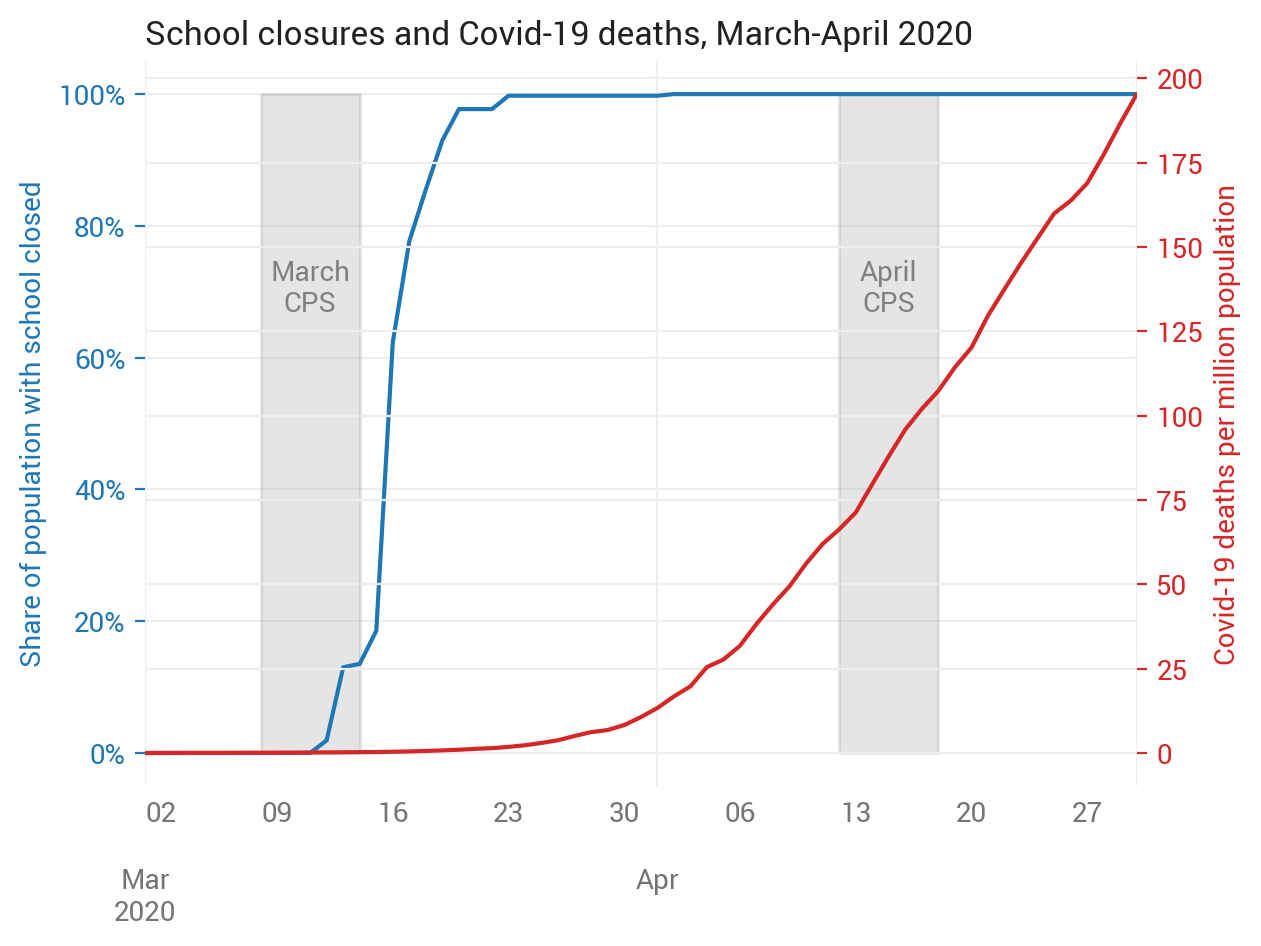

In [18]:
# Colors for distinguishing series in dual axis.
c1 = 'tab:blue'
c2 = 'tab:red'
# Plot first series: population share in areas with schools closed.
ax1 = school_closure_death_trend.pct_pop.plot(c=c1)
ax1.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax1.set_ylabel('Share of population with school closed', color=c1)
ax1.tick_params(axis='y', colors=c1)
ax1.set_xlabel('')
# Shade CPS survey weeks.
ax1.fill_betweenx(y=[0, 1], x1=pd.to_datetime('2020-03-08'), 
                  x2=pd.to_datetime('2020-03-14'), alpha=0.2, color='gray')
ax1.fill_betweenx(y=[0, 1], x1=pd.to_datetime('2020-04-12'),
                  x2=pd.to_datetime('2020-04-18'), alpha=0.2, color='gray')
plt.text(pd.to_datetime('2020-03-11'), 0.67, 'March\nCPS',
         horizontalalignment='center', zorder=10, c='gray')
plt.text(pd.to_datetime('2020-04-15'), 0.67, 'April\nCPS',
         horizontalalignment='center', zorder=10, c='gray')
# Plot second series: Covid-19 deaths per capita (in counties w/ school data).
ax2 = ax1.twinx()
ax2.set_axisbelow(True)
school_closure_death_trend.deaths_pc.plot(ax=ax2, c=c2)
ax2.set_ylabel('Covid-19 deaths per million population', color=c2)
ax2.tick_params(axis='y', colors=c2)
plt.savefig('charts/timeline.png')
plt.title('School closures and Covid-19 deaths, March-April 2020', loc='left')
plt.show()

In [19]:
county_date[county_date.school_closure_date.isna() & (county_date.date == '2020-05-01')].POPESTIMATE2019.sum()

115160235

In [20]:
county_pop_cum

,POPESTIMATE2019,pct_pop
school_closure_date,,
2020-03-12,3934988,0.019230
2020-03-13,26624257,0.130112
2020-03-14,27685340,0.135298
2020-03-15,37936657,0.185396
2020-03-16,127612031,0.623639
2020-03-17,158972814,0.776899
2020-03-18,175042920,0.855433
2020-03-19,190312116,0.930053
2020-03-20,199969355,0.977248
